<a href="https://colab.research.google.com/github/PozzOver13/learning/blob/main/bayesian_modeling/20250305_bayesian_hierachical_models_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Hierarchical Models

## Definizione

I modelli gerarchici bayesiani (Bayesian Hierarchical Models, BHM) sono una classe di modelli statistici che combinano la modellazione gerarchica con l'approccio bayesiano per catturare la struttura multi-livello dei dati e incorporare informazioni a priori.

## Caratteristiche principali
**Struttura Gerarchica**  
* I parametri del modello sono organizzati in più livelli, riflettendo la struttura naturale dei dati (es. individui all'interno di gruppi).
* Le osservazioni condividono parametri comuni, ma ogni sottogruppo può avere caratteristiche specifiche.  

**Approccio Bayesiano**  
* Si utilizza la Regola di Bayes per aggiornare le credenze sui parametri alla luce dei dati osservati.
* Si definiscono distribuzioni a priori per i parametri, che vengono aggiornate in distribuzioni a posteriori.

**Pooling dell'Informazione**

* Complete Pooling: si assume che tutti i gruppi condividano lo stesso parametro (sovrastima la similarità).
* No Pooling: ogni gruppo ha un parametro indipendente (sottostima la similarità).
* Partial Pooling (Shrinking): i parametri di gruppo sono parzialmente vincolati da un livello superiore, ottenendo un compromesso tra complete e no pooling.

## Vantaggi e Svantaggi  
✅ Stime più robuste quando i dati per alcuni gruppi sono scarsi.  
✅ Permette di incorporare conoscenza preesistente tramite distribuzioni a priori.  
✅ Modella naturalmente la variabilità tra gruppi.  

❌ Computazionalmente intensivo (richiede metodi MCMC o VI).  
❌ Sensibile alla scelta della distribuzione a priori.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm

In [2]:


# Impostiamo il seed per replicabilità
np.random.seed(42)

# Definizione delle regioni
regioni = ["Regione 1", "Regione 2"]

# Definizione delle classi energetiche ordinate
classi_energetiche = ["A", "B", "C", "D", "E", "F", "G"]

# Numero di perizie simulate per regione
n_perizie = 500

# Media globale dei prezzi
mu_globale = 1500  # €/mq

# Definiamo effetti specifici per classe energetica (espressi in €/mq rispetto alla media)
effetti_classe = {
    "A": 200,  # Prezzo più alto
    "B": 150,
    "C": 100,
    "D": 50,
    "E": -50,
    "F": -100,
    "G": -200  # Prezzo più basso
}

# Generiamo un dataset con le perizie
dati = []
for regione in regioni:
    # Definiamo una media regionale con una piccola variazione
    mu_regione = mu_globale + np.random.normal(0, 200)  # Media regionale con variazione casuale

    for _ in range(n_perizie):
        classe = np.random.choice(classi_energetiche, p=[0.1, 0.15, 0.2, 0.2, 0.15, 0.1, 0.1])  # Distribuzione casuale

        # Prezzo determinato da media globale, variazione regionale e classe energetica
        prezzo_mq = mu_regione + effetti_classe[classe] + np.random.normal(0, 50)  # Rumore
        dati.append([regione, classe, prezzo_mq])

# Creiamo il DataFrame
df = pd.DataFrame(dati, columns=["Regione", "ClasseEnergetica", "Prezzo_mq"])

# Controlliamo i primi dati generati
df.head()


,Regione,ClasseEnergetica,Prezzo_mq
0,Regione 1,E,1542.429616
1,Regione 1,D,1637.635162
2,Regione 1,A,1787.635983
3,Regione 1,F,1578.303471
4,Regione 1,A,1837.714567


In [3]:
# Statistiche descrittive
df.groupby(["Regione"])["Prezzo_mq"].median()

,Prezzo_mq
Regione,
Regione 1,1654.850765
Regione 2,1472.145890


In [4]:
# Statistiche descrittive
df.groupby(["Regione", "ClasseEnergetica"])["Prezzo_mq"].median()

Regione    ClasseEnergetica
Regione 1  A                   1796.607283
           B                   1747.705167
           C                   1700.393023
           D                   1648.417174
           E                   1558.665546
           F                   1510.294640
           G                   1394.673481
Regione 2  A                   1613.261972
           B                   1571.013444
           C                   1520.959090
           D                   1478.350916
           E                   1367.628243
           F                   1342.740568
           G                   1223.975271
Name: Prezzo_mq, dtype: float64

In [5]:
# Statistiche descrittive
df.groupby(["Regione", "ClasseEnergetica"])["Prezzo_mq"].describe()

count         mean        std          min  \
Regione   ClasseEnergetica                                               
Regione 1 A                  56.0  1796.063246  46.950074  1637.279464   
          B                  77.0  1744.627386  44.607319  1614.498498   
          C                  89.0  1701.806369  52.011032  1595.246360   
          D                 103.0  1647.074476  45.666484  1548.085701   
          E                  65.0  1560.463761  50.472718  1457.299119   
          F                  54.0  1504.296667  48.337847  1397.436604   
          G                  56.0  1399.101590  49.374086  1288.786065   
Regione 2 A                  46.0  1616.730066  43.774149  1528.199685   
          B                  67.0  1567.816880  50.115731  1446.173756   
          C                  92.0  1522.861762  47.932415  1378.046128   
          D                 100.0  1475.174332  50.374650  1360.004902   
          E                  85.0  1366.340273  59.719563  1198.419247   
          F                  61.0  1334.896703  41.873568  1208.610128   
          G                  49.0  1219.316293  39.502874  1144.369345   

                                    25%          50%          75%          max  
Regione   ClasseEnergetica                                                      
Regione 1 A                 1763.875833  1796.607283  1814.962060  1922.504936  
          B                 1717.473474  1747.705167  1776.470833  1842.631556  
          C                 1666.211643  1700.393023  1739.969122  1803.962194  
          D                 1616.713697  1648.417174  1680.555763  1729.002162  
          E                 1522.817773  1558.665546  1593.424818  1741.979405  
          F                 1471.179868  1510.294640  1538.368485  1612.877473  
          G                 1373.360754  1394.673481  1424.102141  1528.010821  
Regione 2 A                 1585.879030  1613.261972  1644.573761  1713.058694  
          B                 1536.436918  1571.013444  1589.991003  1705.618806  
          C                 1487.287267  1520.959090  1552.533606  1656.836406  
          D                 1437.481350  1478.350916  1510.737342  1583.594469  
          E                 1332.335051  1367.628243  1400.957203  1520.710206  
          F                 1312.712428  1342.740568  1358.640217  1413.438340  
          G                 1188.415324  1223.975271  1243.186779  1292.330423

In [6]:
df["log_prezzo_mq"] = log_prezzo_mq = np.log(df.Prezzo_mq + 0.1).values
df = df.sort_values(["Regione", "ClasseEnergetica"], ascending=[True, False])
df.ClasseEnergetica = df.ClasseEnergetica.map(str.strip)

ape, mn_ape = df.ClasseEnergetica.factorize()
df["ape_num"] = ape


In [7]:
df

,Regione,ClasseEnergetica,Prezzo_mq,log_prezzo_mq,ape_num
5,Regione 1,G,1375.869111,7.226914,0
19,Regione 1,G,1440.470076,7.272794,0
22,Regione 1,G,1409.185892,7.250838,0
31,Regione 1,G,1365.496731,7.219347,0
50,Regione 1,G,1374.254978,7.225740,0
...,...,...,...,...,...
948,Regione 2,A,1582.191097,7.366629,6
982,Regione 2,A,1666.892826,7.418777,6
986,Regione 2,A,1528.199685,7.331911,6
989,Regione 2,A,1579.262127,7.364776,6


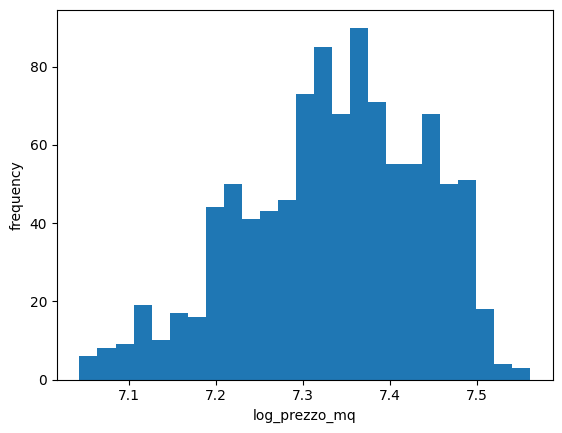

In [8]:
df.log_prezzo_mq.hist(bins=25, grid=False)
plt.xlabel("log_prezzo_mq")
plt.ylabel("frequency");

## Complete Pooling

In [9]:
with pm.Model() as pooled_model:
  floor_ind = pm.MutableData("ape_ind", ape, dims="obs_id")
  alpha = pm.Normal("alpha", 0, sigma=10)
  beta = pm.Normal("beta", mu=0, sigma=10)
  sigma = pm.Exponential("sigma", 5)

  theta = alpha + beta * floor_ind

  y = pm.Normal("y", theta, sigma=sigma, observed=log_prezzo_mq, dims="obs_id")

/usr/local/lib/python3.11/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


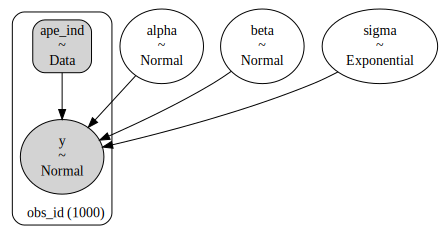

In [10]:
pm.model_to_graphviz(pooled_model)